In [ ]:
# Dalia Tavizon-Dykstra
# DSC 640
# Final Project


# **Driving Market Adaptability: Mortgage Rate Fluctuations and Real Estate Dynamics in Denver**

## Introduction
The Denver-Aurora-Lakewood, CO, real estate market experiences fluctuations influenced by mortgage rate changes. Understanding this relationship is vital for real estate professionals to make informed decisions. This project aims to analyze the impact of mortgage rate fluctuations on key market indicators using Realtor.com and the US Federal Reserve data.

## Dataset Overview
The dataset, sourced from [Realtor.com's data library](https://www.realtor.com/research/data/) and the [US Federal Reserve](https://fred.stlouisfed.org/series/MORTGAGE30US), includes monthly real estate metrics from July 2016 to January 2024. Key variables include median listing price, active listing count, median days on market, new listing count, 30-year mortgage rate, and more, providing a comprehensive view of the market trends over time.This data should help uncover actionable insights for pricing strategies and inventory management decisions.


## Problem Statement & Significance:
Fluctuating mortgage rates in the Denver-Aurora-Lakewood, CO metro area presents challenges for real estate agencies in pricing properties competitively and managing inventory effectively. Understanding the relationship between mortgage rates and market indicators is essential for optimizing pricing strategies and inventory management techniques. Predictive analytics can forecast changes in housing demand based on mortgage rate trends, enabling informed decisions to maximize revenue and market share.

## Target Audience:
Real estate professionals, including agents, brokers, and agencies, are interested in optimizing pricing strategies and inventory management techniques to adapt to market fluctuations effectively.


## Model Selection: Multiple Linear Regression:
The Multiple Linear Regression model will be utilized for its suitability for analyzing the relationship between multiple independent variables, such as mortgage rates, and a dependent variable, such as listing prices or active listing counts. This model allows for quantifying the impact of mortgage rate fluctuations on various real estate market indicators in the Denver-Aurora-Lakewood area. By considering multiple predictors simultaneously, Multiple Linear Regression provides insights into how changes in mortgage rates affect market dynamics.

## Tying into the Business Problem:
Applying the Multiple Linear Regression model will quantify the impact of mortgage rate fluctuations on various real estate market indicators in the Denver-Aurora-Lakewood area. The model will help understand how changes in mortgage rates influence listing prices, active listing counts, median days on the market, and other market dynamics. Insights from regression analysis will enable real estate professionals to make informed decisions regarding pricing strategies, inventory management, and market forecasting, addressing the challenges of fluctuating mortgage rates.


## Evaluation of Results:
Evaluation of results will involve statistical metrics such as R-squared, adjusted R-squared, and p-values to assess the goodness of fit of the regression model. Residual analysis will be conducted to check for heteroscedasticity and normality of residuals. Visualizations will also be used to validate the model's performance, including scatter plots of actual vs. predicted values and residual plots. Additionally, cross-validation techniques such as k-fold cross-validation may be used to assess model robustness and generalization to unseen data.

## Learning Objectives & Risks:
Through this project, I aim to gain insights into the extent to which mortgage rate fluctuations impact real estate market dynamics. I also hope to understand the effectiveness of the Multiple Linear Regression model in predicting changes in market indicators based on mortgage rate trends. Furthermore, I explore how real estate professionals can leverage regression analysis for informed pricing strategies and inventory management decision-making. One potential risk is the presence of multicollinearity among independent variables, which could lead to inaccurate coefficient estimates in the regression model. To mitigate this risk, multicollinearity diagnostics, such as variance inflation factor (VIF) analysis, will be conducted, and variable transformation or elimination strategies will be considered if necessary.

## Conclusion:
In conclusion, this project aims to provide insights into the relationship between mortgage rate fluctuations and real estate market dynamics in the Denver-Aurora-Lakewood, CO, metro area. The analysis offers actionable insights for real estate professionals to optimize pricing strategies and inventory management decisions by employing the Multiple Linear Regression model and rigorous evaluation techniques. Ethical considerations and contingency plans will be integral to the project, ensuring responsible and robust analysis practices.








---

# Import, clean, and prep the Dataset

Importing, cleaning, and prepping the dataset for this analysis.

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mode
from scipy.stats import pearsonr
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error, r2_score

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


# Enabling Data Table Functionality in Google Colab for better DataFrame visualization:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Setting Pandas display options to avoid scientific notation in float numbers for better readability:
pd.options.display.float_format = '{:.2f}'.format

# Loading the dataset
file_path = 'https://raw.githubusercontent.com/dtavizondykstra/Housing-Market-Trends-Project/main/data/RDC_Inventory_Core_Metrics_Metro_History.csv'
data = pd.read_csv(file_path)

# Filtering for the Denver-Aurora-Lakewood, CO metro area
denver_data = data[data['cbsa_title'] == 'Denver-Aurora-Lakewood, CO']

# Preliminary data cleaning
# Convert month_date_yyyymm to a datetime format
denver_data['date'] = pd.to_datetime(denver_data['month_date_yyyymm'], format='%Y%m')

# Displaying the first few rows to verify
# display(denver_data.head())

# Importing and Merging Mortgage Rate Data
mortgage_data = pd.read_csv('https://raw.githubusercontent.com/dtavizondykstra/Housing-Market-Trends-Project/main/data/MORTGAGE30US.csv')

# Converting the 'DATE' column to datetime
mortgage_data['DATE'] = pd.to_datetime(mortgage_data['DATE'])


# Resampling the data to the end of each month and using the mean rate for the month
# (Since the Denver real estate data is monthly,the mortgage rate data will need to be converted to monthly as well)
mortgage_data.set_index('DATE', inplace=True)
monthly_mortgage_data = mortgage_data.resample('M').mean().reset_index()

# Merging the monthly mortgage data with the Denver real estate data
denver_data['date'] = denver_data['date'] + pd.offsets.MonthEnd(0)

# Merging the datasets on the date columns
merged_data = pd.merge(left=denver_data, right=monthly_mortgage_data, left_on='date', right_on='DATE', how='left')

# Checking the first few rows to confirm the merge worked as expected
# merged_data.head()

# Renaming the mortgage rate column and ensuring it's a float-type
merged_data.rename(columns={'MORTGAGE30US': 'average_mortgage_rate'}, inplace=True)
merged_data['average_mortgage_rate'] = merged_data['average_mortgage_rate'].astype(float)

# Removing any rows that didn't have a corresponding mortgage rate
merged_data.dropna(subset=['average_mortgage_rate'], inplace=True)

# Defining the key variables that will be analyzed in this project
variables = ['median_listing_price', 'active_listing_count', 'median_days_on_market',
                 'new_listing_count', 'price_reduced_count', 'pending_listing_count']

# Visualizing the mortgage rates over time
# plt.figure(figsize=(14, 7))
# sns.lineplot(x='date', y='average_mortgage_rate', data=merged_data, marker='o')
# plt.title('Average Mortgage Rates Over Time (2014-2023)')
# plt.xlabel('Date')
# plt.ylabel('Average Mortgage Rate (%)')
# plt.xticks(rotation=45)
# plt.show()





---


# Exploratory Data Analysis (EDA)





### **EDA Part 1: Seasonality Analysis**

Seasonality can significantly influence real estate market trends, with certain times of the year typically showing more activity than others. This section is dedicated to uncovering seasonal patterns in various market indicators such as median listing price, active listing count, median days on market, new listing count, and average mortgage rate.

By extracting the year and month from the dataset's date entries, these variables can be broken down and compared on a monthly basis across different years. This temporal breakdown will allow for the observation and analysis of seasonal trends, such as peaks in buying or selling activity, which are essential for understanding the cyclical nature of the real estate market in the Denver-Aurora-Lakewood, CO metro area.

Visualizing these trends will help identify the times of the year when the market is most active or slow. These insights can provide valuable guidance for buyers, sellers, and investors to strategize accordingly. This analysis will also contribute to a deeper understanding of how external factors and market sentiments are reflected in the real estate cycle.


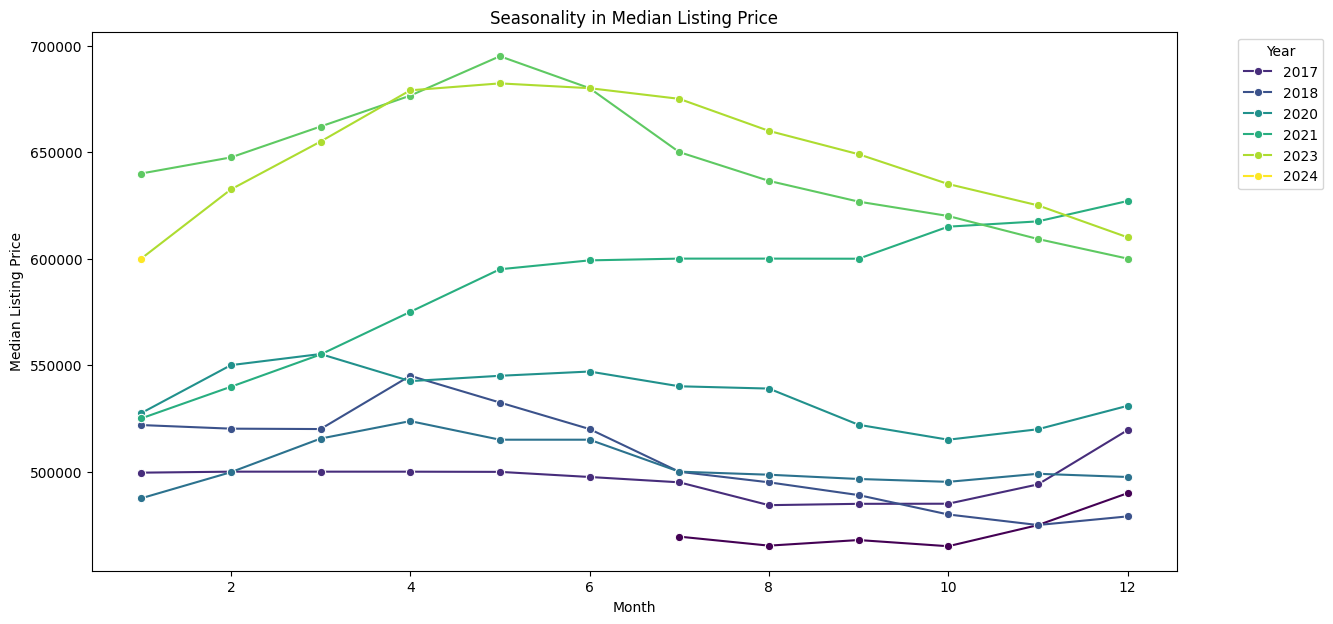

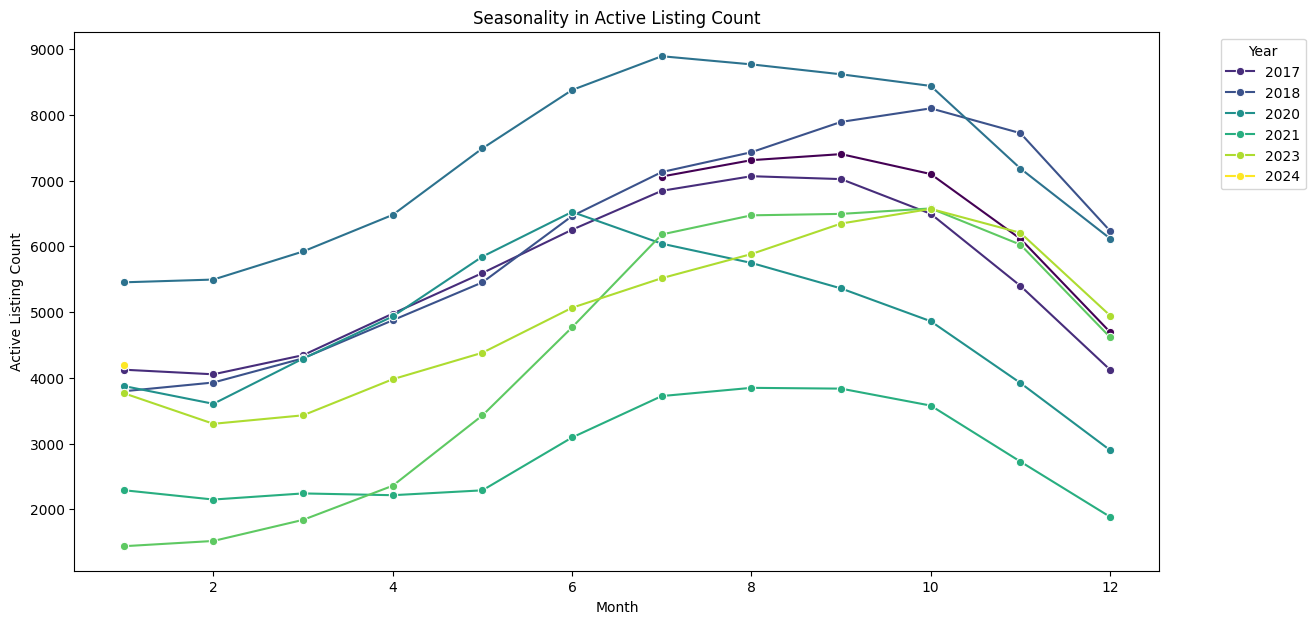

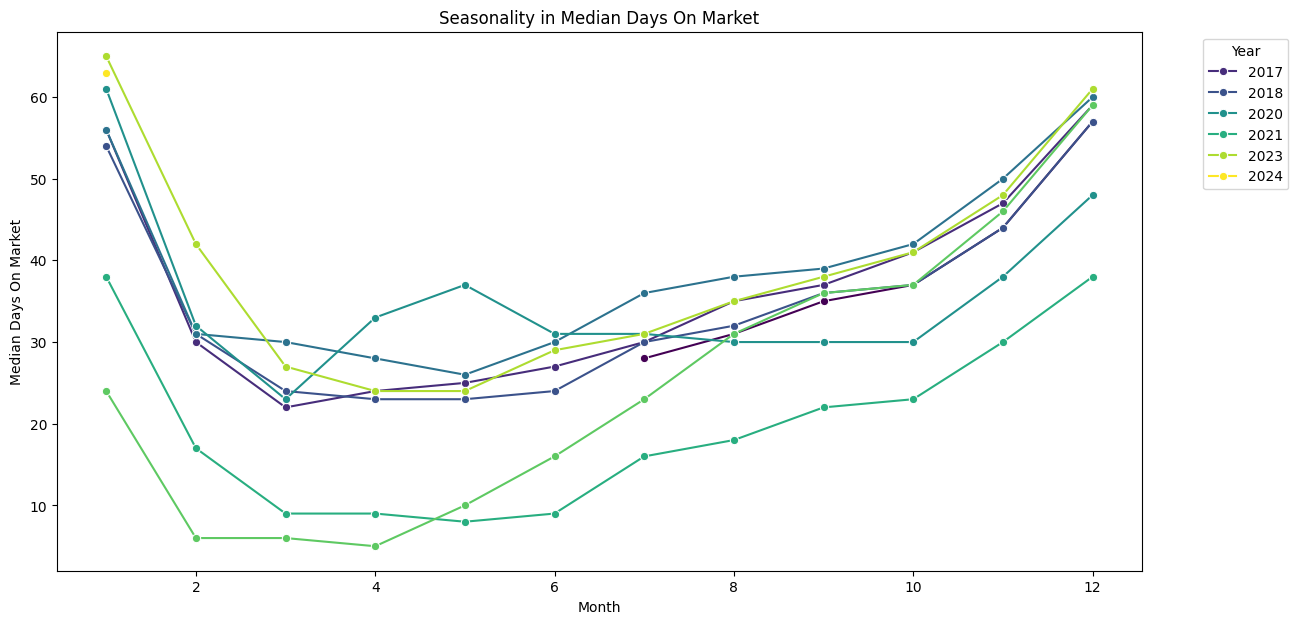

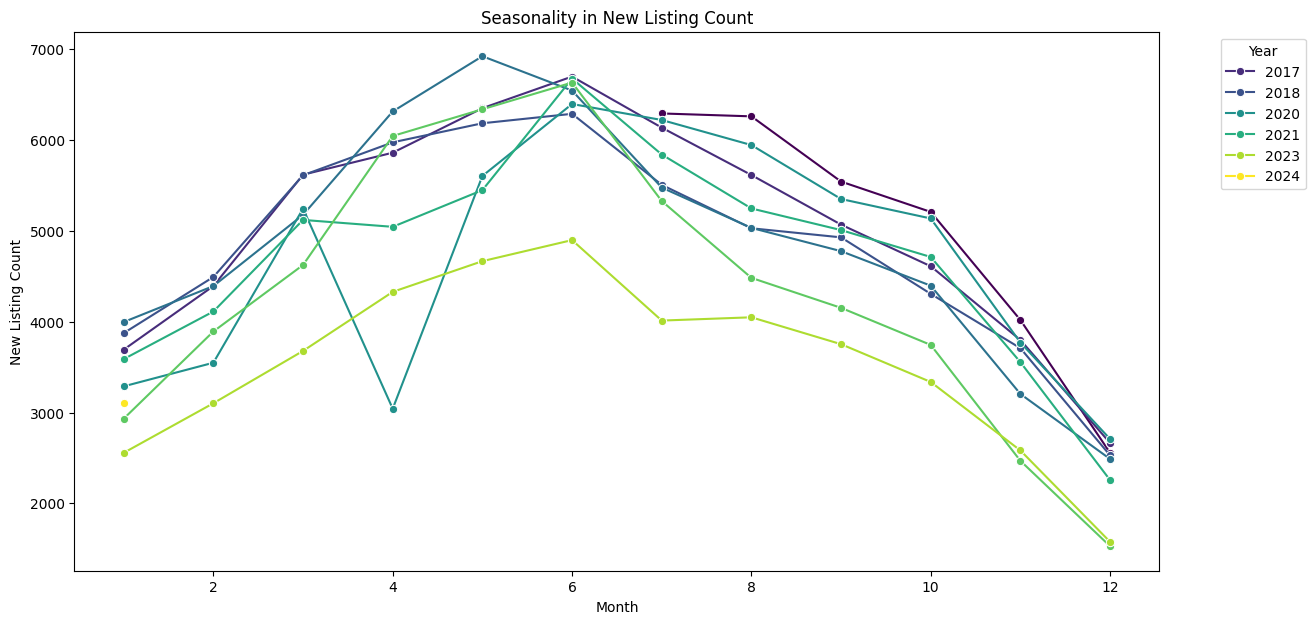

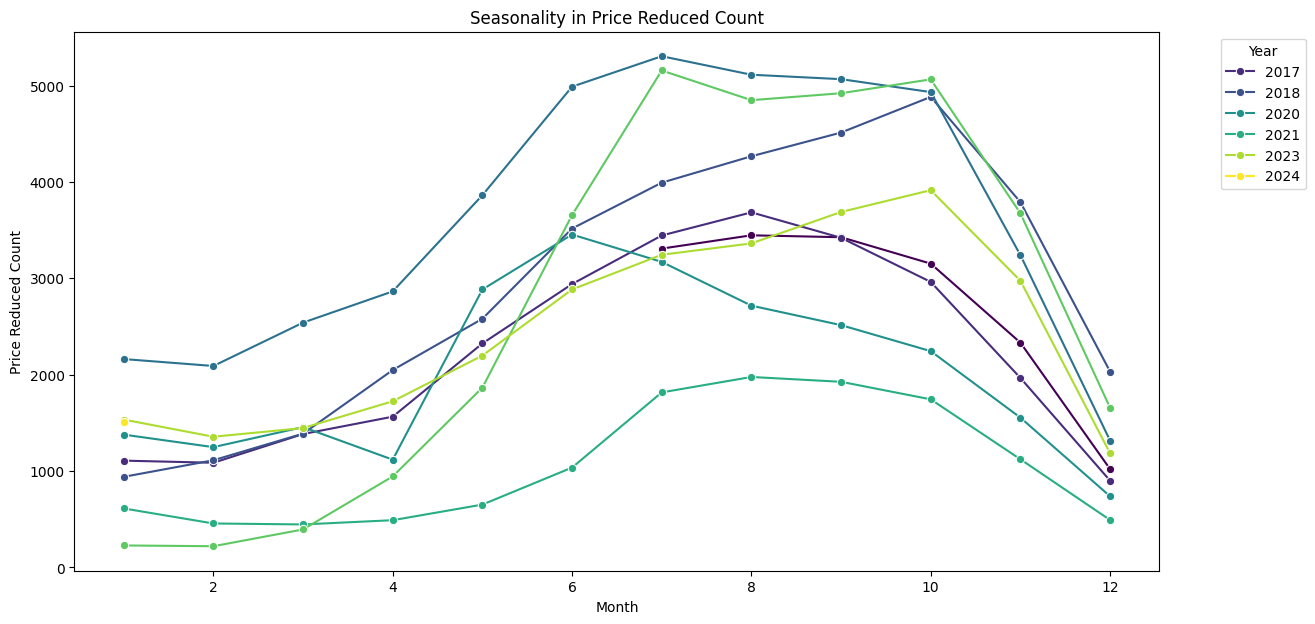

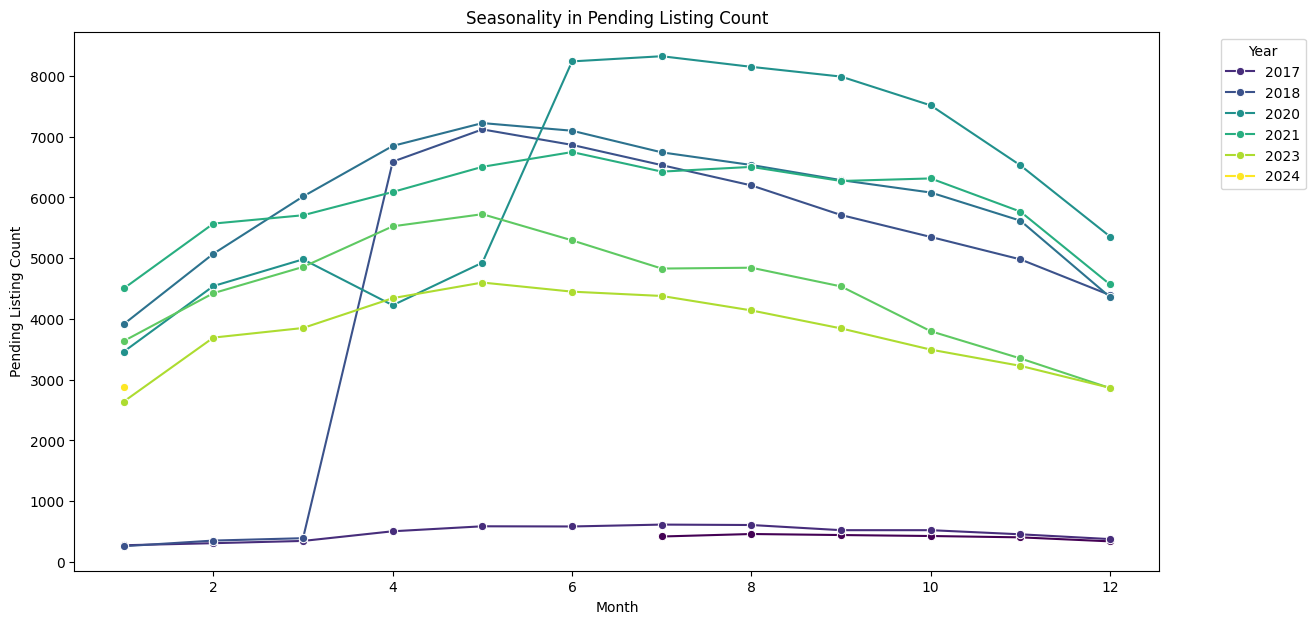

In [ ]:
# Extracting year and month from the date for seasonality analysis
denver_data['year'] = denver_data['date'].dt.year
denver_data['month'] = denver_data['date'].dt.month

# Plotting seasonality trends for all variables
for var in variables:
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='month', y=var, hue='year', data=denver_data, marker='o', palette='viridis')
    plt.title(f'Seasonality in {var.replace("_", " ").title()}')
    plt.xlabel('Month')
    plt.ylabel(var.replace("_", " ").title())
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


### **EDA Part 2: Correlation Analysis**


A comprehensive understanding of the real estate market requires examining the relationships between various market indicators. In this section, a correlation analysis will be conducted to quantitatively assess the strength and direction of relationships between several key variables: median listing price, active listing count, median days on market, new listing count, price reduced count, and pending listing count.

A correlation matrix will be used to visualize these relationships, providing a succinct overview of how these variables interrelate. For instance, the analysis may reveal that higher listing prices correlate with longer days on the market, or that an increase in new listings correlates with an increase in pending sales.

This heatmap will help identify pairs of variables that warrant further investigation. A strong positive or negative correlation could suggest a significant interdependency that could be explored in predictive modeling or used to inform strategic decisions in the market. Through this analysis, the goal is to identify potential drivers of market dynamics and insights that could influence investment and policy-making in the Denver-Aurora-Lakewood, CO metro area.


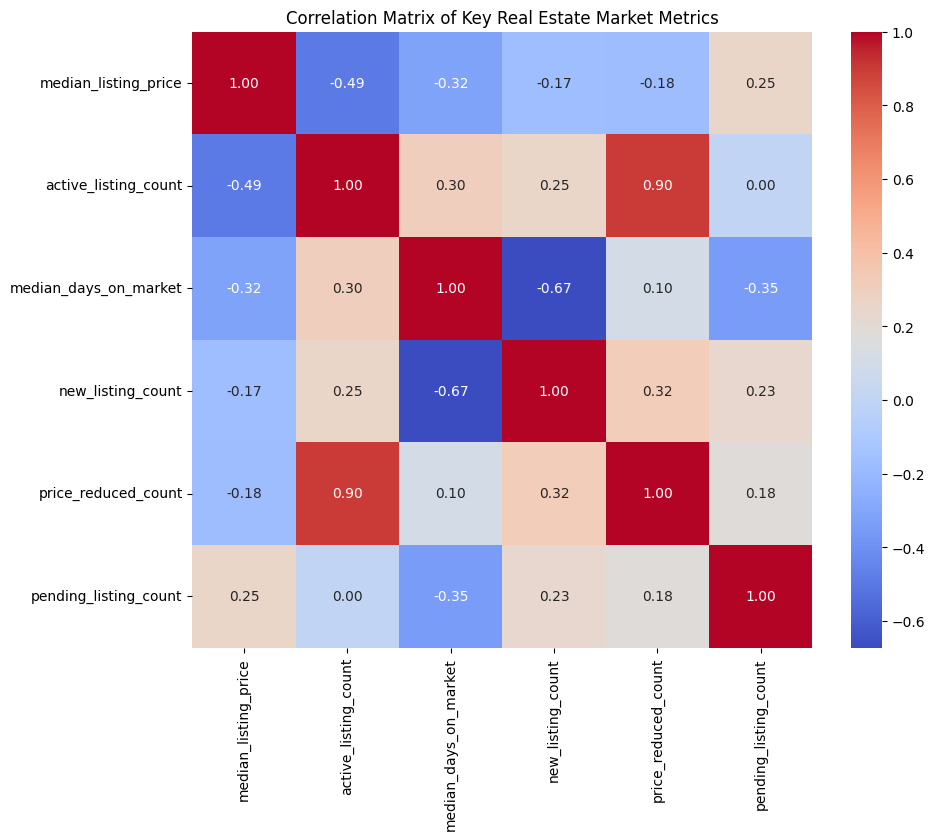

In [ ]:
# Selecting key variables for correlation analysis
key_variables = ['median_listing_price', 'active_listing_count', 'median_days_on_market',
                 'new_listing_count', 'price_reduced_count', 'pending_listing_count']

# Correlation matrix
corr_matrix = denver_data[key_variables].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Real Estate Market Metrics')
plt.show()


### **EDA Part 3: Mortgage Rate Trends Over Time**



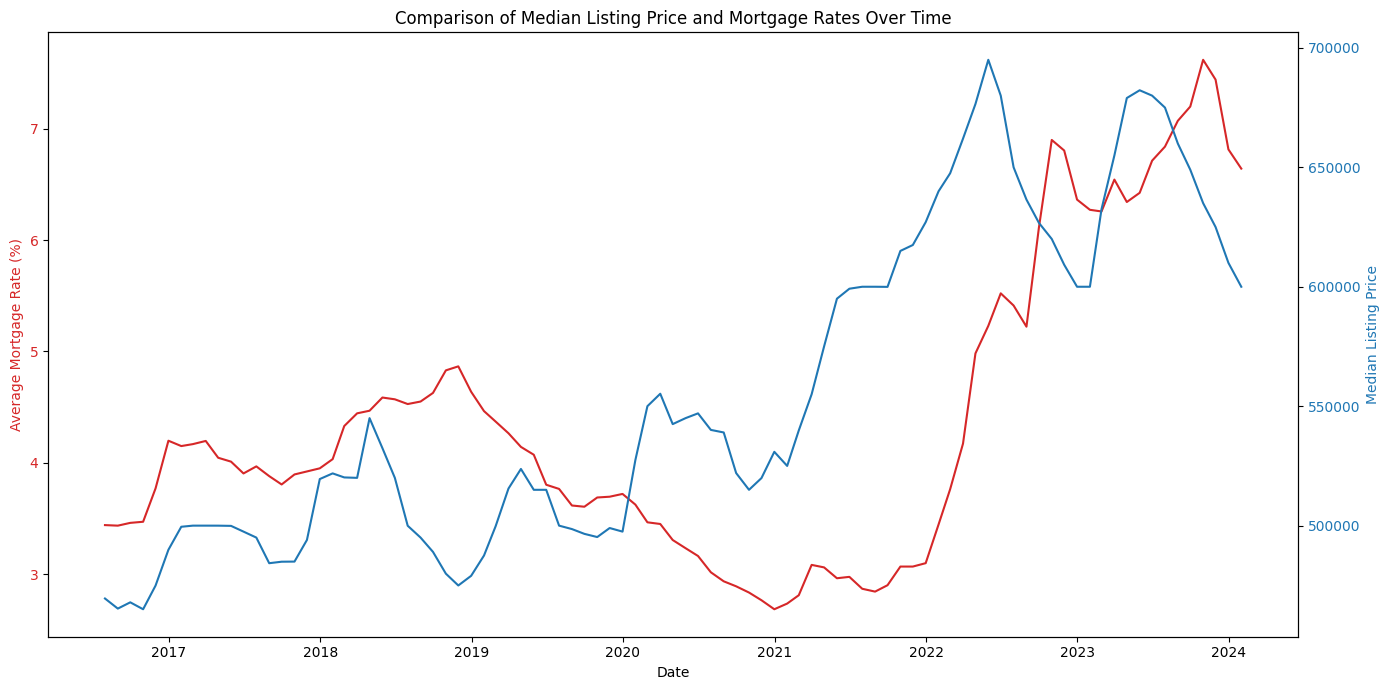

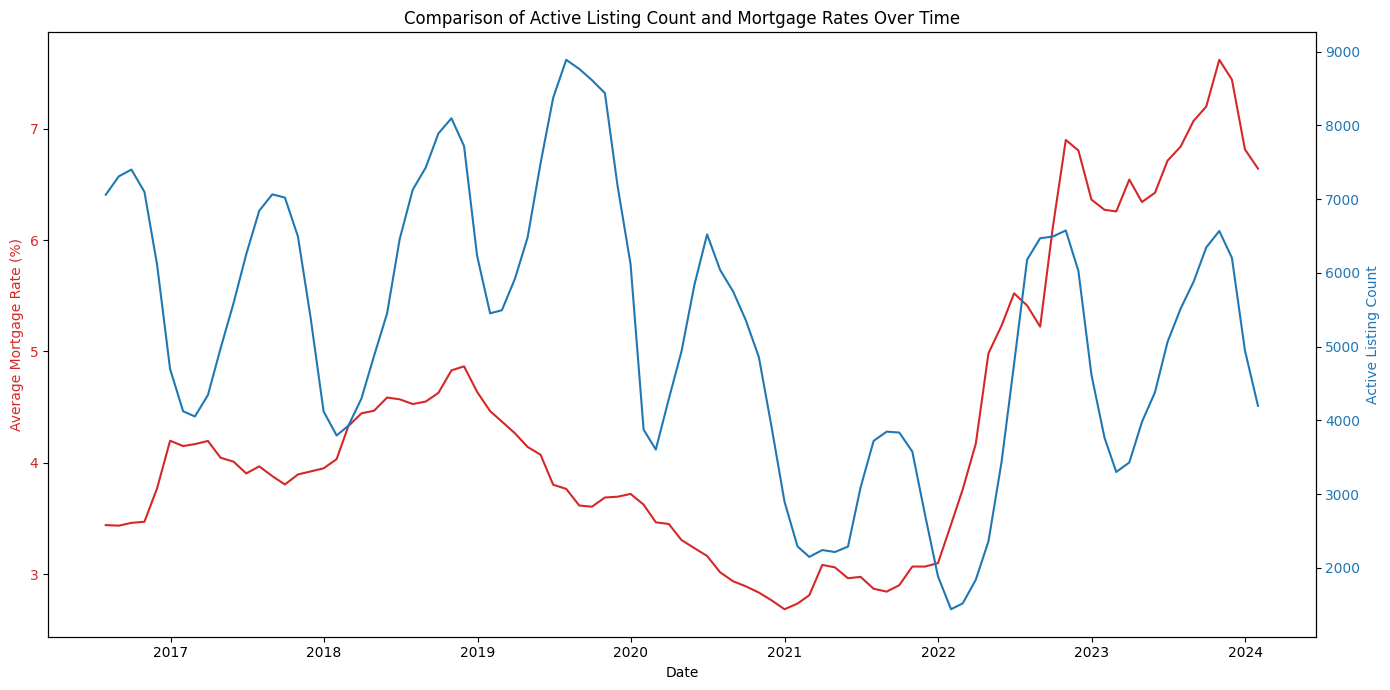

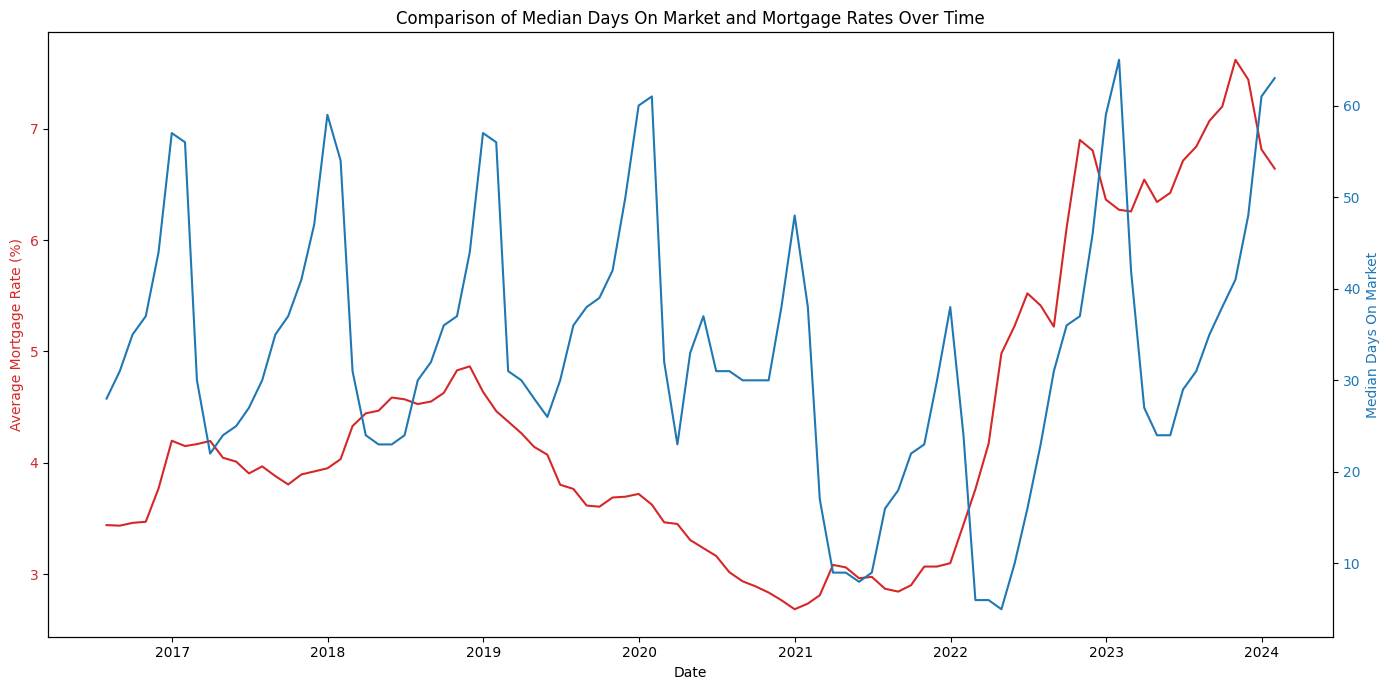

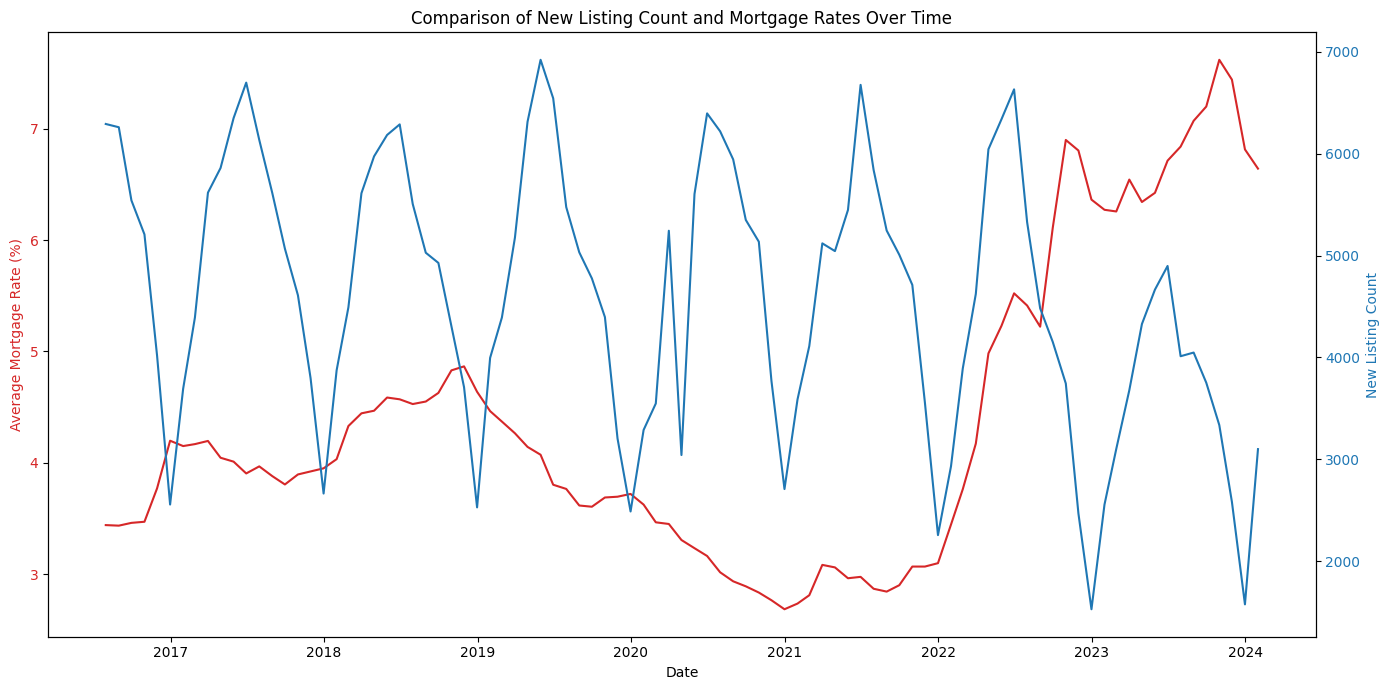

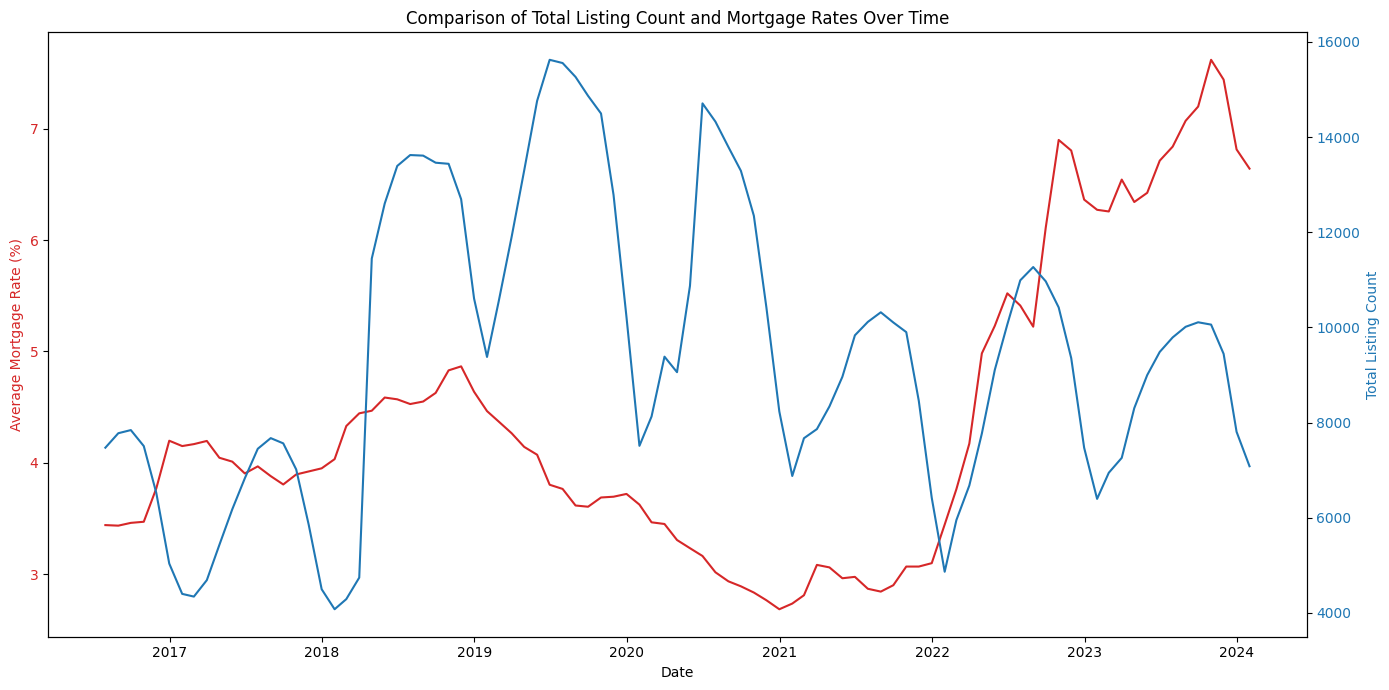

In [ ]:
# Creating line charts with two lines: one for mortgage rates and one for each of the other variables to compare trends

# Indexing the data to `date`
merged_data.set_index('date', inplace=True)

# Creating line charts for the following variables (5):
variables = ['median_listing_price', 'active_listing_count', 'median_days_on_market',
             'new_listing_count', 'total_listing_count']

# Plotting mortgage rates and each variable in the same chart for comparison
for var in variables:
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average Mortgage Rate (%)', color=color)
    ax1.plot(merged_data['average_mortgage_rate'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(var.replace("_", " ").title(), color=color)
    ax2.plot(merged_data[var], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and show plot
    plt.title(f'Comparison of {var.replace("_", " ").title()} and Mortgage Rates Over Time')
    fig.tight_layout()
    plt.show()


# Exploratory Data Analysis Summary & Conclusions

### **EDA Part 1: Seasonality Analysis Summary**
* **Seasonality in Median Listing Price**
  * The chart shows a noticeable trend where median listing prices peak during the mid-year months, potentially indicating a higher demand during the summer, which is a common buying season. This trend is consistent across multiple years, suggesting a strong seasonal effect in the listing prices. Prices tend to rise as the weather warms up and families prefer to move during the summer break from school, which could account for the higher prices observed in those months.
* **Seasonality in Active Listing Count**
  * The active listing count increases in the early months of the year and peaks around the summer before declining towards the end of the year. This pattern could be attributed to sellers choosing to list their properties during the high-demand summer months in anticipation of more buyer activity and potentially higher offers. The consistent seasonal pattern across years underlines the cyclic nature of the real estate market, with a build-up of inventory leading into the summer and a slowdown as the year ends.
* **Seasonality in Median Days on Market**
  * The median days on market for listings are shortest during the summer months, suggesting that properties sell faster during this period. This aligns with the peak buying season when more buyers are active, leading to quicker sales. Conversely, listings take longer to sell at the beginning and the end of the year, which could be due to the holiday season and colder weather, times when buyer activity typically slows down.
* **Seasonality in New Listing Count**
  * The new listing count also shows a clear seasonal pattern, with the highest number of new listings appearing in the spring and peaking in summer. Sellers might be timing the market to capitalize on the increased buyer activity during these months. The trend across different years is consistent, reaffirming the seasonal behavior observed in the real estate market.
* **Seasonality in Total Listing Count**
  * The total listing count, which includes both active and new listings, exhibits a strong seasonal pattern with inventory building up towards the summer months and tapering off towards the year's end. The peak during the summer months is likely due to both an increase in new listings and active listings remaining on the market from the spring. The decline in the later months of the year could be a result of listings being sold or taken off the market during the slower winter season.

### **EDA Part 2: Correlation Matrix Summary**
* **Strong Positive Correlation (0.90):**
  * More active listings often lead to more price reductions, indicating a trend for real estate professionals to adjust prices when inventory increases.
* **Strong Negative Correlation (-0.67):**
  * An increase in new listings tends to decrease the median days on the market, suggesting properties sell faster when there are more new listings.

### **EDA Part 3: Mortgage Rate Trends Over Time Summary**
* **Comparison of Median Listing Price and Mortgage Rates Over Time**
  * The chart suggests a relationship between median listing prices and mortgage rates over time. It appears that as mortgage rates decrease, the median listing prices tend to increase and vice versa. This inverse relationship might indicate that lower borrowing costs encourage buyers to enter the market, driving up demand and prices. Conversely, higher mortgage rates could discourage buyers, leading to a cooling effect on prices. However, there are periods where this trend does not hold, suggesting other factors are also at play influencing home prices.
* **Comparison of Active Listing Count and Mortgage Rates Over Time**
  * The active listing count and mortgage rates show less of a clear inverse relationship. There are periods where both move in the same direction, which could suggest that other market dynamics, such as economic factors or housing supply constraints, are influencing the number of active listings independent of mortgage rate fluctuations.
* **Comparison of Median Days on Market and Mortgage Rates Over Time**
  * This chart illustrates that median days on market tend to rise as mortgage rates increase, which could indicate a slowing market. Higher borrowing costs may lead to fewer buyers, which extends the time listings remain on the market. However, there are also periods where days on market decrease even when mortgage rates rise, implying that factors other than mortgage rates, such as housing demand and seasonal trends, are affecting how long homes stay listed before sale.
* **Comparison of New Listing Count and Mortgage Rates Over Time**
  * The new listing count does not show a consistent pattern in relation to mortgage rates. While there are instances where an increase in mortgage rates corresponds with a decrease in new listings, suggesting sellers might be hesitant to list during periods of high borrowing costs, there are also times when the two metrics appear uncorrelated. This inconsistency could be due to the fact that the decision to list a property is influenced by a variety of factors, including personal circumstances, market sentiment, seasonality, and long-term economic expectations.
* **Comparison of Total Listing Count and Mortgage Rates Over Time**
  * For total listing count, the relationship with mortgage rates is complex and non-linear. While one might expect higher mortgage rates to lead to fewer listings as market activity slows, the chart shows that the total number of listings can be affected by other variables such as seasonality, the overall state of the economy, and specific local market conditions.

### **EDA Conclusion**
* In conclusion, the insights derived from correlation analysis, mortgage rate trends, and seasonality analysis offer invaluable guidance for real estate professionals navigating the dynamic housing market. By understanding the relationships between key market metrics, such as active listing count and price reductions, professionals can adapt pricing strategies in response to changing inventory levels. For instance, when there's an uptick in active listings, indicating increased competition, adjusting prices strategically can help properties stand out in a crowded market.
* Moreover, the influence of mortgage rates on market dynamics is profound. For instance, observing how median listing prices fluctuate in response to changes in mortgage rates provides critical insights into buyer behavior. When mortgage rates decrease, there's often a surge in buyer demand as affordability improves, leading to higher median listing prices. Conversely, when mortgage rates rise, buyers may become more cautious, resulting in a slowdown in price growth.
* Furthermore, recognizing seasonal patterns in market metrics empowers professionals to anticipate shifts in buyer and seller activity. For example, understanding that new listing counts typically peak in the spring and summer months allows agents to plan marketing campaigns and allocate resources effectively during periods of heightened listing activity. By aligning listing strategies with seasonal trends, professionals can optimize exposure and maximize the likelihood of successful transactions.
* In essence, leveraging these insights equips real estate professionals with the knowledge and foresight needed to navigate the complexities of the housing market successfully. By integrating data-driven analysis into decision-making processes, professionals can enhance competitiveness, capitalize on market opportunities, and ultimately drive success in the ever-evolving real estate landscape.







---
# **Data prepartion for model**

Now that the data has been collected and EDA has been completed, the data preparation process for the model will begin. The following section will encompass a wide array of data preparation steps -- listed below -- and also apply any findings from the EDA.

* Drop any features that are not useful for model building
* Perform any data extraction/selection steps.
* Transform features if necessary.
* Engineer new useful features.
* Deal with missing data
* Create dummy variables if necessary.
* Incorporate/apply any findings learned from EDA



### **Dropping Features Not Useful for Model Building**

**Documentation of dropped features**
* Dropped `cbsa_code` and `cbsa_title` as they are regional identifiers unnecessary for this focused analysis.
* Dropped `householdRank` due to it not being relevant to this analysis
* Dropped `month_date_yyyymm` and `DATE` so no redundant date information is present.
* Dropped columns ending in "mm" and "yy" (aggregated month-over-month or year-over-year deltas) to eliminate noise from short-term fluctuations, focusing on more stable metrics.

In [ ]:
# View the columns in the Dataset
# for col in merged_data:
#   print(col)

# Creating a list of unnecessary features
features_to_drop = [
    'cbsa_code',
    'cbsa_title',
    'HouseholdRank',
    'month_date_yyyymm',
    'DATE',
    'median_listing_price_mm',
    'median_listing_price_yy',
    'active_listing_count_mm',
    'active_listing_count_yy',
    'median_days_on_market_mm',
    'median_days_on_market_yy',
    'new_listing_count_mm',
    'new_listing_count_yy',
    'price_increased_count_mm',
    'price_increased_count_yy',
    'price_reduced_count_mm',
    'price_reduced_count_yy',
    'pending_listing_count_mm',
    'pending_listing_count_yy',
    'median_listing_price_per_square_foot_mm',
    'median_listing_price_per_square_foot_yy',
    'median_square_feet_mm',
    'median_square_feet_yy',
    'average_listing_price_mm',
    'average_listing_price_yy',
    'total_listing_count_mm',
    'total_listing_count_yy',
    'pending_ratio_mm',
    'pending_ratio_yy',
    'quality_flag',
    'pending_ratio',
    'average_listing_price',
    'active_listing_count',
    'pending_listing_count',
    'median_listing_price_per_square_foot',
    'new_listing_count'
  ]


# Dropping unecessary features
merged_data.drop(features_to_drop, axis=1, inplace=True)


### **Checking for and Handling Missing Data**

**Documentation of Missing Data**
* No missing data present that needs handling.


In [ ]:
# Checking for missing values
print(merged_data.isna().sum())

median_listing_price     0
median_days_on_market    0
price_increased_count    0
price_reduced_count      0
median_square_feet       0
total_listing_count      0
average_mortgage_rate    0
dtype: int64


### **Checking for multicollinearty**
* Examining the Variance Inflation Factor (VIF) for each independent variable; doing so important to assess multicollinearity among variables. (Multicollinearity can affect the reliability of the regression analysis.)
* Scores below 10 are generally considered good, indicating a low risk of multicollinearity.

In [ ]:
# Adding a constant
X = add_constant(merged_data)

# Creating a DataFrame to store VIF results
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                 feature    VIF
0                  const 915.86
1   median_listing_price   5.67
2  median_days_on_market   2.29
3  price_increased_count   3.18
4    price_reduced_count   3.60
5     median_square_feet   1.77
6    total_listing_count   3.06
7  average_mortgage_rate   3.20


### **Feature Transformation**

**Documentation of feature transformation**
* Based on the finding of seasonality being present in the data (during the EDA) -- I decided to apply sine and cosine funtions to the month data as this approach should better capture the cyclical patterns. These functions create a continuous cyclical representation, accurately reflecting the proximity of December and January, which should lead to improved accuracy in predictions.

In [ ]:
# Extracting month from the index (date)
merged_data['month'] = merged_data.index.month

# Encoding month using sine and cosine functions
merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['month']/12)
merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['month']/12)

# Dropping 'month' since it's no longer needed
merged_data.drop('month', axis=1, inplace=True)




---
# **Multiple Regression Analysis**
Running a multiple regression analysis and summarizing the results.

### **Preparing the data for Linear Regression**

* Final check: Reviewing the DataFrame, ensurring the data looks as expected, looking for any outliers or anomalies that might affect the model.



In [ ]:
# Final Check 1: To ensure dataframe looks correct/no anomolies, etc.
# merged_data.head()

In [ ]:
# Final Check 2: To look for nulls, outliers, etc.
# merged_data.describe()

### **Splitting the dataset**

In [ ]:
# Splitting the data into test and train datasets:

# Making the target variable 'median_listing_price'
X = merged_data.drop('median_listing_price', axis=1)
y = merged_data['median_listing_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### **Running the Multiple Linear Regression**

In [ ]:
# Adding a constant to the model
X_train_sm = sm.add_constant(X_train)

# Fitting the model
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Printing results
print(results.summary())


                             OLS Regression Results                             
Dep. Variable:     median_listing_price   R-squared:                       0.856
Model:                              OLS   Adj. R-squared:                  0.838
Method:                   Least Squares   F-statistic:                     46.74
Date:                  Sun, 26 May 2024   Prob (F-statistic):           1.28e-23
Time:                          23:00:34   Log-Likelihood:                -832.62
No. Observations:                    72   AIC:                             1683.
Df Residuals:                        63   BIC:                             1704.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

### **Regression Results Interpretation**

* In my analysis using ordinary least squares regression, I achieved a strong model fit with an R-squared value of 0.856, indicating that the model can explain approximately 85.6% of the variability in median listing prices. The adjusted R-squared of 0.838 reflects a high level of explanatory power even after adjusting for the number of predictors. The model's overall significance is confirmed by an F-statistic of 46.74 and a highly significant p-value (`1.28e-23`), suggesting that the model is statistically robust.
* Regression coefficients reveal that variables such as the average mortgage rate have a substantial positive impact on the median listing price, increasing it by about `$25,170` for each unit increase in the rate. In contrast, variables like price increased count and median days on the market have negative effects. For example, an increase in the median days on the market leads to a decrease in the median listing price by approximately `$1,286` per unit increase. This negative coefficient is statistically significant and indicates that properties staying longer on the market tend to sell for less.
* Seasonality, captured through sine and cosine transformations of months, also shows significant effects. The cosine transformation of the month notably decreases the listing price by about `$24,310`, indicating significant seasonal impacts on property prices. The sine transformation, while also indicating a decrease of approximately `$16,090` in listing prices, shows a weaker influence as its effect is marginally significant (`p = 0.056`).
* It's important to note that the condition number is quite high, indicating potential issues with multicollinearity or other numerical problems that might affect the precision of the regression coefficients, as quoted in the notes section of the results. This suggests a need for further investigation into the relationships between variables or possible refinement of the model to address these issues.




### **Evaluating the Model on the Test Set**
* To evaluate the model's performance on unseen data, I will use the test set. This step is crucial to ensure the model generalizes well and does not overfit to the training data.


R-squared: 0.8274652934810571


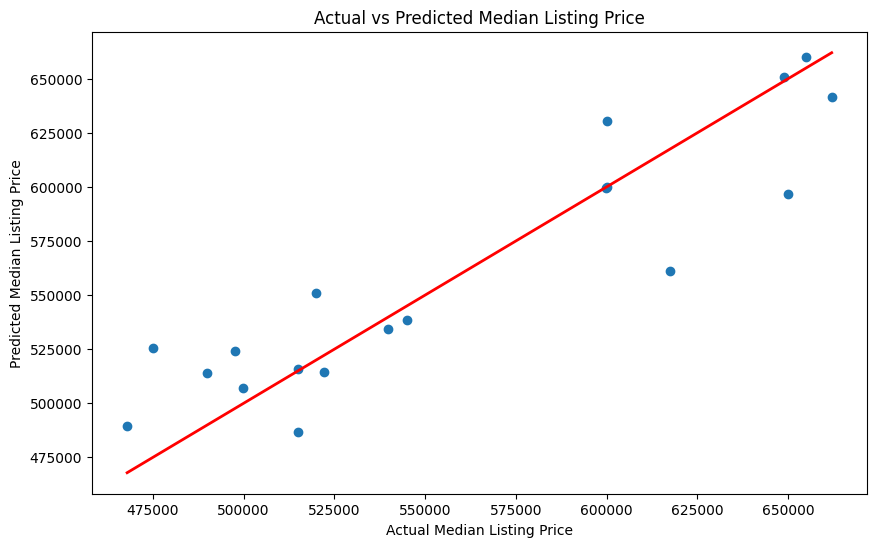

In [ ]:
# Adding a constant to the test set
X_test_sm = sm.add_constant(X_test)

# Making predictions on the test set
y_pred = results.predict(X_test_sm)

# Calculating the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Plotting the actual vs predicted values to visually inspect the model's performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Median Listing Price')
plt.ylabel('Predicted Median Listing Price')
plt.title('Actual vs Predicted Median Listing Price')
plt.show()


### **Results Interpretation: Evaluating the Model on the Test Set**

###### **R-Squared**

The evaluation of my model on the test set produced the following result:
* R-squared (R²): 0.827

The R-squared value of 0.827 suggests that 82.7% of the variability in the median listing prices is explained by the model. This indicates strong explanatory power, meaning the model captures a significant portion of the underlying trends and relationships in the data.

###### **Visual Inspection**
* The scatter plot of actual vs. predicted median listing prices shows that the predicted values are closely aligned with the actual values. The points are generally close to the red line representing perfect predictions, indicating good model performance.

Overall, the high R-squared value and the scatter plot confirm that the model generalizes well to new, unseen data, effectively predicting median listing prices based on the given variables. Additionally, this supports the model's utility for real estate professionals in making informed decisions.